In [1]:
import argparse
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from azureml.studio.core.io.data_frame_directory import load_data_frame_from_directory, save_data_frame_to_directory, DataFrameDirectory
from azureml.studio.core.io.transformation_directory import save_pickle_transform_to_directory, TransformationDirectory, PickleTransformationDirectory

In [2]:
input_dataset = 'samples_data/dataset'
number_of_dimensions = 5
normalize = True
solver = 'randomized'
output_dataset = 'samples_data/transformed'
output_model = 'samples_data/transform'
output_eigenvectors = 'samples_data/eigen'

PCA_SOLVERS = ['auto', 'full', 'arpack', 'randomized']

In [126]:
data_folder = load_data_frame_from_directory(input_dataset)

if any([col['type'] != 'Numeric' for col in data_folder.schema['columnAttributes']]):
    raise TypeError('Dataset contains non-numeric columns. Cannot apply PCA to non-numeric types.')

if number_of_dimensions <= 0:
    raise ValueError('The number of components cannot be less or equal to zero.')

if solver not in PCA_SOLVERS:
    raise ValueError(f'Solver {solver} is not a valid PCA solver. Possible values are {PCA_SOLVERS}')

data = data_folder.data
tranformations = []

if normalize:
    scaler = StandardScaler().fit(data)
    data = scaler.transform(data)
    tranformations.append(('normalize', scaler))

pca = PCA(n_components=number_of_dimensions, svd_solver=solver, whiten=True).fit(data)
transformed_data = pca.transform(data)
tranformations.append(('pca', pca))

tranformations_pipe = Pipeline(tranformations)

components_name = [f"Component{chr(65 + index)}" for index in range(0, number_of_dimensions)]
df = pd.DataFrame(data = transformed_data, columns = components_name)

save_data_frame_to_directory(output_dataset, df)
save_pickle_transform_to_directory(output_model, tranformations_pipe)

if output_eigenvectors:
    eigenvectors = pd.DataFrame(data = pca.components_.T, columns = components_name)
    save_data_frame_to_directory(output_eigenvectors, eigenvectors)

/home/santiagxf/miniconda3/envs/mlops/lib/python3.8/site-packages/azureml/studio/core/io/data_frame_utils.py:77: FutureWarning: the 'fname'' keyword is deprecated, use 'path' instead
  df.to_parquet(fname=parquet_file_name, engine=_PARQUET_ENGINE,


In [101]:
transform = PickleTransformationDirectory(output_model).load(Path(output_model))

In [38]:
df = pd.DataFrame(data = pca.components_.T, columns = components_name)

In [39]:
df

,ComponentA,ComponentB,ComponentC,ComponentD,ComponentE
0,0.170444,-0.137462,0.866119,0.057547,-0.202923
1,0.345221,-0.048651,0.252843,-0.038842,-0.071916
2,0.395936,0.002096,0.052471,-0.063171,-0.008564
3,0.407348,0.055763,-0.065217,-0.021818,-0.029416
4,0.412088,0.112566,-0.154234,0.011716,-0.062761
5,0.405701,0.120218,-0.209025,0.016196,-0.093953
6,0.381263,0.144716,-0.192913,-0.081496,-0.049271
7,-0.208738,0.311503,-0.057677,-0.280225,-0.871791
8,-0.041923,0.551919,0.089282,0.392213,0.011742
9,-0.042797,0.542626,0.130988,0.448746,0.123797


In [3]:
import pandas as pd
from sklearn.cluster import FeatureAgglomeration
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [40]:
input_dataset = 'samples_data/dataset'
number_of_features = 6
normalize = True
output_dataset = 'samples_data/transformed'
output_model = 'samples_data/transform'

In [5]:
data_folder = load_data_frame_from_directory(input_dataset)

In [7]:
data = data_folder.data
tranformations = []

In [8]:
if normalize:
    scaler = StandardScaler().fit(data)
    data = scaler.transform(data)
    tranformations.append(('normalize', scaler))

In [65]:
from sklearn.neighbors import kneighbors_graph

#connectivity = kneighbors_graph(data.T, 6, include_self=False)
connectivity = grid_to_graph(1, data[0].shape[0])

In [63]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data

In [66]:
agglo = FeatureAgglomeration(connectivity=connectivity, n_clusters=number_of_features, compute_distances=True).fit(data)

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram

In [67]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

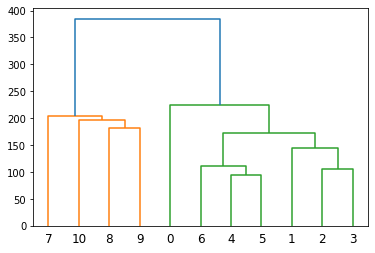

In [68]:
plot_dendrogram(agglo)

In [69]:
transformed_data = agglo.transform(data)

In [70]:
transformed_data.shape

(24000, 6)

In [71]:
data.shape

(24000, 11)

In [75]:
agglo.labels_

array([5, 0, 0, 0, 0, 0, 0, 3, 2, 4, 1])